In [114]:
!pip install pyspark


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [115]:
from prophet import Prophet

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pyspark.sql import SparkSession

import pyspark.sql.functions as F
from pyspark.sql.functions import col, sum
import warnings
warnings.filterwarnings('ignore')

In [117]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [118]:
path = '/content/drive/MyDrive/Chicago_Crimes_2012_to_2017.csv'

In [119]:
# creating a spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder\
                    .master("local")\
                    .appName(" crime rate prediciton ")\
                    .getOrCreate()\

sc = spark.sparkContext

In [120]:
df = spark.read.csv(path, header=True, inferSchema=True)

In [121]:
df.show()

+----+--------+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
| _c0|      ID|Case Number|                Date|               Block|IUCR|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+----+--------+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|   3|10508693|   HZ250496|05/03/2016 11:40:...|  013XX S SAWYER AVE|0486|             BATTERY|DOMESTIC BATTE

In [122]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- ID: integer (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: double (nullable = true)
 |-- Ward: double (nullable = true)
 |-- Community Area: double (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: double (nullable = true)
 |-- Y Coordinate: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



In [123]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [124]:
# can extract the date column correct 
from pyspark.sql.functions import split, to_date, hour, minute

# Split datetime column into separate date and time columns
df = df.withColumn("date_col", to_date(split("Date", " ")[0], "M/d/y"))

In [125]:
df.Year

Column<'Year'>

In [126]:
# Convert the "Date" column to timestamp type
df = df.withColumn('Date', F.to_timestamp('Date', 'MM/dd/yyyy hh:mm:ss a'))

**Main code start here.**

In [128]:
columns_to_drop = ['_c0', 'Case Number', 'IUCR', 'X Coordinate', 'Y Coordinate', 'Updated On',
                    'FBI Code', 'Beat', 'Ward', 'Community Area', 'Latitude', 'Longitude']
df = df.drop(*columns_to_drop)

In [129]:
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- District: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Location: string (nullable = true)
 |-- date_col: date (nullable = true)



In [130]:
# Drop rows with any null values
df_without_nulls = df.dropna()

# Display the DataFrame without null values
df_without_nulls.show()

+--------+-------------------+--------------------+--------------------+--------------------+--------------------+------+--------+--------+----+--------------------+----------+
|      ID|               Date|               Block|        Primary Type|         Description|Location Description|Arrest|Domestic|District|Year|            Location|  date_col|
+--------+-------------------+--------------------+--------------------+--------------------+--------------------+------+--------+--------+----+--------------------+----------+
|10508693|2016-05-03 23:40:00|  013XX S SAWYER AVE|             BATTERY|DOMESTIC BATTERY ...|           APARTMENT|  true|    true|    10.0|2016|(41.864073157, -8...|2016-05-03|
|10508695|2016-05-03 21:40:00|  061XX S DREXEL AVE|             BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|     3.0|2016|(41.782921527, -8...|2016-05-03|
|10508697|2016-05-03 23:31:00| 053XX W CHICAGO AVE|PUBLIC PEACE VIOL...|    RECKLESS CONDUCT|              STREET| 

In [131]:
from pyspark.sql.functions import to_timestamp, date_format

# Assuming the date string is in a DataFrame column called 'date_str'
df = df.withColumn('date', to_timestamp('date', 'MM/dd/yyyy HH:mm:ss'))
df = df.withColumn('formatted_date', date_format('date', 'MM/dd/yyyy HH:mm:ss'))

In [132]:
df.select("date").show()


+-------------------+
|               date|
+-------------------+
|2016-05-03 23:40:00|
|2016-05-03 21:40:00|
|2016-05-03 23:31:00|
|2016-05-03 22:10:00|
|2016-05-03 22:00:00|
|2016-05-03 22:35:00|
|2016-05-03 22:30:00|
|2016-05-03 21:30:00|
|2016-05-03 16:00:00|
|2016-05-03 22:30:00|
|2016-05-03 21:44:00|
|2016-05-03 23:11:00|
|2016-05-03 17:30:00|
|2016-05-03 09:00:00|
|2016-05-03 22:08:00|
|2016-05-03 16:00:00|
|2016-05-03 21:45:00|
|2016-05-03 22:00:00|
|2016-05-03 20:00:00|
|2016-05-03 23:00:00|
+-------------------+
only showing top 20 rows



In [133]:
from pyspark.sql.functions import to_date



# Extract the date part
df = df.withColumn('date_1', to_date('date', 'MM/dd/yyyy HH:mm:ss'))

# Show the resulting DataFrame
df.select('date_1').show()


+----------+
|    date_1|
+----------+
|2016-05-03|
|2016-05-03|
|2016-05-03|
|2016-05-03|
|2016-05-03|
|2016-05-03|
|2016-05-03|
|2016-05-03|
|2016-05-03|
|2016-05-03|
|2016-05-03|
|2016-05-03|
|2016-05-03|
|2016-05-03|
|2016-05-03|
|2016-05-03|
|2016-05-03|
|2016-05-03|
|2016-05-03|
|2016-05-03|
+----------+
only showing top 20 rows



In [134]:
from pyspark.sql.types import DateType

# Cast the column to DateType explicitly
df = df.withColumn('date_1', to_date('date', 'MM/dd/yyyy HH:mm:ss').cast(DateType()))

# Show the resulting DataFrame
df.select('date_1').show()


+----------+
|    date_1|
+----------+
|2016-05-03|
|2016-05-03|
|2016-05-03|
|2016-05-03|
|2016-05-03|
|2016-05-03|
|2016-05-03|
|2016-05-03|
|2016-05-03|
|2016-05-03|
|2016-05-03|
|2016-05-03|
|2016-05-03|
|2016-05-03|
|2016-05-03|
|2016-05-03|
|2016-05-03|
|2016-05-03|
|2016-05-03|
|2016-05-03|
+----------+
only showing top 20 rows



In [135]:
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- District: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Location: string (nullable = true)
 |-- date_col: date (nullable = true)
 |-- formatted_date: string (nullable = true)
 |-- date_1: date (nullable = true)



In [136]:
crime_count = df.groupBy('Primary Type').count()
crime_count.show()

+--------------------+------+
|        Primary Type| count|
+--------------------+------+
|OFFENSE INVOLVING...| 11398|
|            STALKING|   828|
|PUBLIC PEACE VIOL...| 13122|
|           OBSCENITY|   187|
|NON-CRIMINAL (SUB...|     4|
|               ARSON|  2217|
|            GAMBLING|  2212|
|   CRIMINAL TRESPASS| 36912|
|             ASSAULT| 91289|
|      NON - CRIMINAL|    38|
|LIQUOR LAW VIOLATION|  1953|
| MOTOR VEHICLE THEFT| 61138|
|               THEFT|329460|
|             BATTERY|263700|
|             ROBBERY| 57313|
|            HOMICIDE|  2649|
|    PUBLIC INDECENCY|    62|
| CRIM SEXUAL ASSAULT|  6823|
|   HUMAN TRAFFICKING|    28|
|        INTIMIDATION|   662|
+--------------------+------+
only showing top 20 rows



In [137]:
# Group the data by date and count the number of crimes
daily_crime_counts = df.groupBy('date_1').count().orderBy('date_1')

# Convert Spark DataFrame to Pandas DataFrame
daily_crime_counts_pd = daily_crime_counts.toPandas()

# Rename the columns for Prophet compatibility
df_1 = daily_crime_counts_pd.rename(columns={'date_1': 'ds', 'count': 'y'})
print(df_1)

              ds     y
0     2012-01-01  1451
1     2012-01-02   700
2     2012-01-03   805
3     2012-01-04   799
4     2012-01-05   871
...          ...   ...
1840  2017-01-14   649
1841  2017-01-15   600
1842  2017-01-16   611
1843  2017-01-17   659
1844  2017-01-18   655

[1845 rows x 2 columns]


In [138]:
df_1['ds'] =pd.to_datetime(df_1['ds'])

In [139]:
df_1 =df_1[['ds','y']]
df_1.head(5)

,ds,y
0,2012-01-01,1451
1,2012-01-02,700
2,2012-01-03,805
3,2012-01-04,799
4,2012-01-05,871


In [140]:
df_1.tail(5)

,ds,y
1840,2017-01-14,649
1841,2017-01-15,600
1842,2017-01-16,611
1843,2017-01-17,659
1844,2017-01-18,655


In [141]:
df_1.dtypes

ds    datetime64[ns]
y              int64
dtype: object

<Axes: xlabel='ds'>

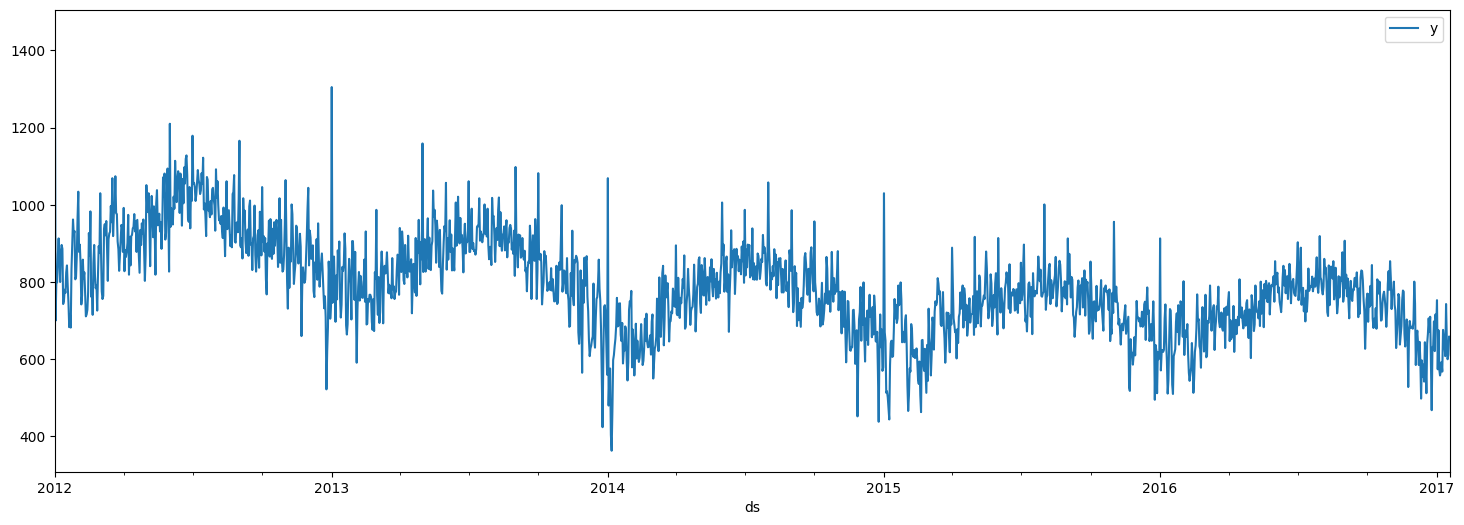

In [142]:
import matplotlib.pyplot as plt
df_1.plot(x ='ds',y='y',figsize=(18,6))

In [143]:
len(df_1)

1845

In [144]:
#row_count = len(df_1)  # Get the number of rows in the DataFrame

#train = df_1.iloc[:row_count-365]  # Select the training data
#test = df_1.iloc[row_count-365:]  # Select the test data

# Print the resulting DataFrames
#print(train)
#print(test)

In [145]:
import pandas as pd

# Assuming df_1 is your original DataFrame with a date column

start_date = '2012-01-01'  # Specify the start date of your desired date range
end_date = '2017-01-18'    # Specify the end date of your desired date range

# Convert the date column to datetime if it's not already in datetime format
df_1['ds'] = pd.to_datetime(df_1['ds'])

# Filter the DataFrame based on the desired date range
train = df_1[(df_1['ds'] >= start_date) & (df_1['ds'] <= end_date)]

# Select the test data by excluding the training data
test = df_1[df_1['ds'] > end_date]

# Print the resulting DataFrames
print(train)
print(test)


             ds     y
0    2012-01-01  1451
1    2012-01-02   700
2    2012-01-03   805
3    2012-01-04   799
4    2012-01-05   871
...         ...   ...
1840 2017-01-14   649
1841 2017-01-15   600
1842 2017-01-16   611
1843 2017-01-17   659
1844 2017-01-18   655

[1845 rows x 2 columns]
Empty DataFrame
Columns: [ds, y]
Index: []


In [146]:
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods =365)
forcast = m.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1uw01nev/z6qc5sah.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1uw01nev/8ateq1l0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85598', 'data', 'file=/tmp/tmp1uw01nev/z6qc5sah.json', 'init=/tmp/tmp1uw01nev/8ateq1l0.json', 'output', 'file=/tmp/tmp1uw01nev/prophet_modelrjim96iz/prophet_model-20230517225013.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:50:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:50:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [147]:
forcast.tail(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2200,2018-01-09,723.563427,517.392314,684.779922,710.690693,735.199325,-119.862015,-119.862015,-119.862015,-8.646336,-8.646336,-8.646336,-111.215679,-111.215679,-111.215679,0.0,0.0,0.0,603.701412
2201,2018-01-10,723.564057,527.073114,694.966508,710.654079,735.236406,-108.635784,-108.635784,-108.635784,-0.035880,-0.035880,-0.035880,-108.599904,-108.599904,-108.599904,0.0,0.0,0.0,614.928273
2202,2018-01-11,723.564687,526.971832,692.089403,710.617466,735.280020,-112.767938,-112.767938,-112.767938,-7.078529,-7.078529,-7.078529,-105.689409,-105.689409,-105.689409,0.0,0.0,0.0,610.796748
2203,2018-01-12,723.565316,569.061279,746.076037,710.580853,735.340171,-60.885239,-60.885239,-60.885239,41.670756,41.670756,41.670756,-102.555995,-102.555995,-102.555995,0.0,0.0,0.0,662.680077
2204,2018-01-13,723.565946,550.893435,721.422644,710.544239,735.400322,-91.335948,-91.335948,-91.335948,7.940168,7.940168,7.940168,-99.276117,-99.276117,-99.276117,0.0,0.0,0.0,632.229998
2205,2018-01-14,723.566576,518.145958,694.001728,710.510512,735.384732,-119.633736,-119.633736,-119.633736,-23.704511,-23.704511,-23.704511,-95.929226,-95.929226,-95.929226,0.0,0.0,0.0,603.932839
2206,2018-01-15,723.567205,539.046019,713.548334,710.484794,735.393952,-102.741725,-102.741725,-102.741725,-10.145669,-10.145669,-10.145669,-92.596056,-92.596056,-92.596056,0.0,0.0,0.0,620.825480
2207,2018-01-16,723.567835,540.579356,706.495080,710.459075,735.443253,-98.003211,-98.003211,-98.003211,-8.646336,-8.646336,-8.646336,-89.356875,-89.356875,-89.356875,0.0,0.0,0.0,625.564624
2208,2018-01-17,723.568464,550.527260,722.706253,710.433356,735.492554,-86.325629,-86.325629,-86.325629,-0.035880,-0.035880,-0.035880,-86.289750,-86.289750,-86.289750,0.0,0.0,0.0,637.242835
2209,2018-01-18,723.569094,540.146239,722.682798,710.407637,735.541855,-90.547397,-90.547397,-90.547397,-7.078529,-7.078529,-7.078529,-83.468867,-83.468867,-83.468867,0.0,0.0,0.0,633.021697


In [148]:

forcast[['ds','yhat','yhat_lower','yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
2200,2018-01-09,603.701412,517.392314,684.779922
2201,2018-01-10,614.928273,527.073114,694.966508
2202,2018-01-11,610.796748,526.971832,692.089403
2203,2018-01-12,662.680077,569.061279,746.076037
2204,2018-01-13,632.229998,550.893435,721.422644
2205,2018-01-14,603.932839,518.145958,694.001728
2206,2018-01-15,620.825480,539.046019,713.548334
2207,2018-01-16,625.564624,540.579356,706.495080
2208,2018-01-17,637.242835,550.527260,722.706253
2209,2018-01-18,633.021697,540.146239,722.682798


In [149]:
from prophet.plot import plot_plotly
plot_plotly(m,forcast)

In [150]:
row_count = len(df_1)  # Get the number of rows in the DataFrame

train = df_1.iloc[:row_count-365]  # Select the training data
test = df_1.iloc[row_count-365:]  # Select the test data

In [151]:
from statsmodels.tools.eval_measures import rmse

predictions = forcast.iloc[-365:]["yhat"]
print(predictions)
print('The calculated RMSE:', rmse(predictions, test['y']))
print('Mean of test data:', test['y'].mean())



1845    635.868296
1846    686.644534
1847    654.498728
1848    623.955044
1849    638.099987
           ...    
2205    603.932839
2206    620.825480
2207    625.564624
2208    637.242835
2209    633.021697
Name: yhat, Length: 365, dtype: float64
The calculated RMSE: 57.235414477319026
Mean of test data: 725.2246575342466


In [153]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Obtain the actual values
actual = test['y']

# Obtain the forecasted values
forecasted = forcast['yhat'].tail(len(test))

# Calculate MAE and MSE
mae = mean_absolute_error(actual, forecasted)
mse = mean_squared_error(actual, forecasted)

print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)




Mean Absolute Error (MAE): 44.75169305017412
Mean Squared Error (MSE): 3275.8926703905


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Step 1: Obtain the forecasted data from fbprophet
forcast = m.predict(future)  # Assuming you already have a trained fbprophet model and future data

# Extract the ds and y values from the forecasted data
ds = forcast['ds'].values
y = forcast['trend'].values

# Step 2: Preprocess the data
# Scale the y values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler.fit_transform(y.reshape(-1, 1))

# Split the data into training and testing sets
train_size = int(len(y_scaled) * 0.8)
train_data = y_scaled[:train_size]
test_data = y_scaled[train_size:]

# Reshape the data into the required input shape for LSTM (samples, time steps, features)
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 10  # Specify the length of input sequences
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Step 3: Define and train the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Step 4: Use the trained LSTM model to make predictions
predictions = model.predict(X_test)

# Inverse scaling of predictions
predictions_scaled = scaler.inverse_transform(predictions)

# Print the predicted values
print(predictions_scaled)


In [154]:
 import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt


# Step 1: Obtain the forecasted data from fbprophet
forecast_data = forcast[['ds', 'yhat']]

# Step 2: Preprocess the data
# Scale the y values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler.fit_transform(forecast_data['yhat'].values.reshape(-1, 1))

# Reshape the data into the required input shape for LSTM (samples, time steps, features)
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 10  # Specify the length of input sequences
X_train, y_train = create_sequences(y_scaled, sequence_length)

# Step 3: Define and train the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Step 4: Use the trained LSTM model to make predictions
X_test = y_scaled[-sequence_length:].reshape(1, sequence_length, 1)
predictions = model.predict(X_test)

# Inverse scaling of predictions
predicted_value = scaler.inverse_transform(predictions)[0][0]

print('Predicted value:', predicted_value)


Epoch 1/10
69/69 [==============================] - 5s 17ms/step - loss: 0.0225
Epoch 2/10
69/69 [==============================] - 1s 15ms/step - loss: 0.0024
Epoch 3/10
69/69 [==============================] - 1s 19ms/step - loss: 0.0024
Epoch 4/10
69/69 [==============================] - 2s 25ms/step - loss: 0.0024
Epoch 5/10
69/69 [==============================] - 2s 25ms/step - loss: 0.0024
Epoch 6/10
69/69 [==============================] - 2s 24ms/step - loss: 0.0023
Epoch 7/10
69/69 [==============================] - 2s 26ms/step - loss: 0.0023
Epoch 8/10
69/69 [==============================] - 2s 26ms/step - loss: 0.0023
Epoch 9/10
69/69 [==============================] - 1s 19ms/step - loss: 0.0023
Epoch 10/10
1/1 [==============================] - 1s 773ms/step
Predicted value: 627.4282


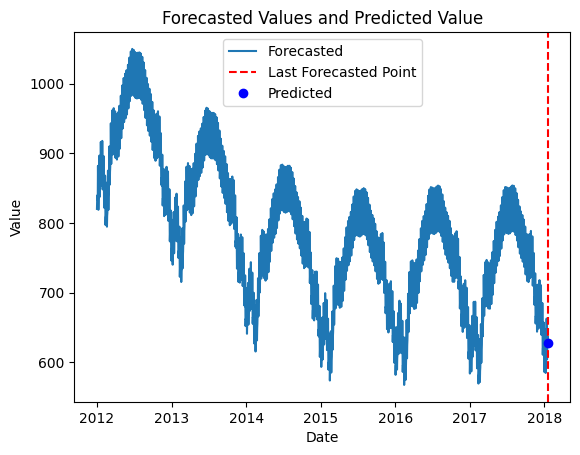

In [155]:
# Step 5: Plot the forecasted values and predicted value
plt.plot(forecast_data['ds'], forecast_data['yhat'], label='Forecasted')
plt.axvline(x=forecast_data['ds'].values[-1], color='r', linestyle='--', label='Last Forecasted Point')
plt.plot(forecast_data['ds'].values[-1], predicted_value, 'bo', label='Predicted')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Forecasted Values and Predicted Value')

# Display the legend
plt.legend()

# Show the plot
plt.show()


In [156]:
# Step 5: Calculate MSE and MAE
actual_values = forecast_data['yhat'].values[-sequence_length:]

# Inverse scaling of actual values
actual_values_scaled = scaler.inverse_transform(actual_values.reshape(-1, 1))

# Inverse scaling of predictions
predicted_value_scaled = scaler.inverse_transform(predictions)[0][0]

# Calculate MSE and MAE
mse = np.mean((actual_values_scaled - predicted_value_scaled)**2)
mae = np.mean(np.abs(actual_values_scaled - predicted_value_scaled))

print('Mean Squared Error (MSE):', mse)
print('Mean Absolute Error (MAE):', mae)


Mean Squared Error (MSE): 90806660327.30624
Mean Absolute Error (MAE): 301229.3319911648
